## MovieLen-100k data

## Initial setting for GGColab

In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=f87da04238a3e879e95f36bfe57fae0e4641ab00b2c1a375fbfa2a9a0161b444
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%pwd

'/content'

In [5]:
%cd "/content/drive/Othercomputers/Tam's Laptop/Desktop/study/rec_sys/als"

/content/drive/Othercomputers/Tam's Laptop/Desktop/study/rec_sys/als


In [6]:
%pwd

"/content/drive/Othercomputers/Tam's Laptop/Desktop/study/rec_sys/als"

## Preprocessing

In [7]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import *
from recommenders.datasets.spark_splitters import spark_random_split
from recommenders.evaluation.spark_evaluation import SparkRankingEvaluation, SparkRatingEvaluation
from recommenders.tuning.parameter_sweep import generate_param_grid
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandas as pd

In [8]:
# Read data
spark = SparkSession.builder.appName("ALS rec sys").getOrCreate()
mv_rating = spark.read.csv("data/ratings.csv", header=True, inferSchema=True)

mv_rating.show()


+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|     31|   2.5|1260759144|
|     1|   1029|   3.0|1260759179|
|     1|   1061|   3.0|1260759182|
|     1|   1129|   2.0|1260759185|
|     1|   1172|   4.0|1260759205|
|     1|   1263|   2.0|1260759151|
|     1|   1287|   2.0|1260759187|
|     1|   1293|   2.0|1260759148|
|     1|   1339|   3.5|1260759125|
|     1|   1343|   2.0|1260759131|
|     1|   1371|   2.5|1260759135|
|     1|   1405|   1.0|1260759203|
|     1|   1953|   4.0|1260759191|
|     1|   2105|   4.0|1260759139|
|     1|   2150|   3.0|1260759194|
|     1|   2193|   2.0|1260759198|
|     1|   2294|   2.0|1260759108|
|     1|   2455|   2.5|1260759113|
|     1|   2968|   1.0|1260759200|
|     1|   3671|   3.0|1260759117|
+------+-------+------+----------+
only showing top 20 rows



In [9]:
# Show random 5 rows:
mv_rating.sample(False, 0.1).show(5)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|     31|   2.5|1260759144|
|     2|     62|   3.0| 835355749|
|     2|    144|   3.0| 835356016|
|     2|    153|   4.0| 835355441|
|     2|    261|   4.0| 835355681|
+------+-------+------+----------+
only showing top 5 rows



In [10]:
# Count how many customer in the dataframe
mv_rating.createOrReplaceTempView('movielen')
spark.sql("SELECT Count(distinct userId) from movielen").show()

+----------------------+
|count(DISTINCT userId)|
+----------------------+
|                   671|
+----------------------+



In [11]:
# Add random age and gender to each user:
# age: random with range (18-50)
# gender: random in list (0: female, 1: male)
# --------------------------------------

# get distinct userid:
userids = spark.sql('select distinct userId from movielen').collect()
userids = [u['userId'] for u in userids]
print('user ids:', userids[:5])

# create a random age and gender dataframe for each userids:
random.seed(96)
user_age_gender_random_list = \
    [(u, random.randrange(18, 50), random.choice([0, 1])) for u in userids]
print('user_age_gender_random_list', user_age_gender_random_list[:5])

user_age_gender_random_df = spark.createDataFrame(
    user_age_gender_random_list, 
    ['userId', 'age', 'gender']
)
print('after random assigning age and gender:')
user_age_gender_random_df.show(5)

# merge to main df:
mv_rating = mv_rating.join(
    user_age_gender_random_df,
    on = 'userId',
    how = 'left'
)

user ids: [148, 463, 471, 496, 243]
user_age_gender_random_list [(148, 41, 1), (463, 43, 0), (471, 24, 1), (496, 20, 0), (243, 28, 1)]
after random assigning age and gender:
+------+---+------+
|userId|age|gender|
+------+---+------+
|   148| 41|     1|
|   463| 43|     0|
|   471| 24|     1|
|   496| 20|     0|
|   243| 28|     1|
+------+---+------+
only showing top 5 rows



In [12]:
# check null for all cols:
mv_rating.select(
    [count(when(col(c).isNull(), c)).alias(c) for c in mv_rating.columns]
    ).show()

mv_rating.show(5)
mv_rating.printSchema()


+------+-------+------+---------+---+------+
|userId|movieId|rating|timestamp|age|gender|
+------+-------+------+---------+---+------+
|     0|      0|     0|        0|  0|     0|
+------+-------+------+---------+---+------+

+------+-------+------+----------+---+------+
|userId|movieId|rating| timestamp|age|gender|
+------+-------+------+----------+---+------+
|     1|     31|   2.5|1260759144| 36|     0|
|     1|   1029|   3.0|1260759179| 36|     0|
|     1|   1061|   3.0|1260759182| 36|     0|
|     1|   1129|   2.0|1260759185| 36|     0|
|     1|   1172|   4.0|1260759205| 36|     0|
+------+-------+------+----------+---+------+
only showing top 5 rows

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)
 |-- age: long (nullable = true)
 |-- gender: long (nullable = true)



## Train model:

In [13]:
# Assigning global variables:
USER_COL = "userId"
ITEM_COL = "movieId"
RATING_COL = "rating"
PREDICT_COL = "prediction"
REC_QUANTITY = 5


In [14]:
# train test split:
df_train, df_test = mv_rating.randomSplit([0.7, 0.3], seed = 96)

In [15]:
# TRAIN MODEL WITH DEFAULT PARAMS:
#---------------------------------
als = ALS(
    userCol=    USER_COL, 
    itemCol=    ITEM_COL, 
    ratingCol=  RATING_COL, 
    coldStartStrategy="drop")

model = als.fit(df_train)

In [16]:
# prediction on test dataset:
df_test_prd = model.transform(df_test)
df_test_prd.show()

+------+-------+------+----------+---+------+----------+
|userId|movieId|rating| timestamp|age|gender|prediction|
+------+-------+------+----------+---+------+----------+
|     1|     31|   2.5|1260759144| 36|     0|  2.331211|
|     1|   1129|   2.0|1260759185| 36|     0| 2.8302352|
|     1|   1287|   2.0|1260759187| 36|     0| 3.2167149|
|     1|   1293|   2.0|1260759148| 36|     0| 2.8833427|
|     1|   1343|   2.0|1260759131| 36|     0| 2.4378438|
|     1|   2968|   1.0|1260759200| 36|     0| 3.7492554|
|     2|     39|   5.0| 835355604| 27|     1| 2.8952727|
|     2|     50|   4.0| 835355586| 27|     1| 3.6414037|
|     2|    110|   4.0| 835355532| 27|     1| 3.7529802|
|     2|    153|   4.0| 835355441| 27|     1| 2.5824373|
|     2|    165|   3.0| 835355441| 27|     1|  2.878324|
|     2|    185|   3.0| 835355511| 27|     1| 3.0617256|
|     2|    235|   3.0| 835355664| 27|     1| 2.3823333|
|     2|    248|   3.0| 835355896| 27|     1| 2.9341023|
|     2|    265|   5.0| 8353556

In [18]:
# Evalualtion:
#------------------------------------------
evaluations = SparkRatingEvaluation(
    df_test, 
    df_test_prd,
    col_user=USER_COL,
    col_item=ITEM_COL,
    col_rating=RATING_COL,
    col_prediction=PREDICT_COL
)

print(
    "RMSE score = {}".format(evaluations.rmse()),
)


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


RMSE score = 0.9279849484836914


In [ ]:
users = df_train.select(USER_COL).distinct()
items = df_train.select(ITEM_COL).distinct()
user_item = users.crossJoin(items)
user_item.show()

In [ ]:
df_train_cross_pred = model.transform(user_item)
df_train_cross_pred.show()

In [ ]:
df_train.show()

In [ ]:
# # Remove seen movies:
# df_train_cross_pred.createOrReplaceTempView('df_train_cross_pred')
# df_train.createOrReplaceTempView('df_train')

# df_train_exclude_seen_item_prd = spark.sql(f'''
#     SELECT 
#         pred.*
#     FROM df_train_cross_pred AS pred
#     FULL OUTER JOIN df_train AS train
#     ON pred.{USER_COL} = train.{USER_COL} AND pred.{ITEM_COL} = train.{ITEM_COL}
#     WHERE train.userId IS NULL
# ''')
# df_train_exclude_seen_item_prd.show()


In [ ]:
# evaluations = SparkRankingEvaluation(
#     df_test, 
#     df_train_exclude_seen_item_prd,
#     col_user=USER_COL,
#     col_item=ITEM_COL,
#     col_rating=RATING_COL,
#     col_prediction=PREDICT_COL,
#     k = REC_QUANTITY
# )

# print(
#     "Precision@k = {}".format(evaluations.precision_at_k()),
#     "Recall@k = {}".format(evaluations.recall_at_k()),
#     "NDCG@k = {}".format(evaluations.ndcg_at_k()),
#     "Mean average precision = {}".format(evaluations.map_at_k()),
#     sep="\n"
# )

## Finetuning model

Prediction performance of a Spark ALS model is often affected by the parameters

|Parameter|Description|Default value|Notes|
|-------------|-----------------|------------------|-----------------|
|`rank`|Number of latent factors|10|The larger the more intrinsic factors considered in the factorization modeling.|
|`regParam`|Regularization parameter|1.0|The value needs to be selected empirically to avoid overfitting.|
|`maxIters`|Maximum number of iterations|10|The more iterations the better the model converges to the optimal point.|

It is always a good practice to start model building with default parameter values and then sweep the parameter in a range to find the optimal combination of parameters. The following parameter set is used for training ALS models for comparison study purposes.

### 1st time:

In [19]:
param_dict = {
    "rank": [20, 30, 40],
    "regParam": [0.001, 0.1, 1.0],
    # 'maxIter': [7, 10, 15, 20]
}
param_grid = generate_param_grid(param_dict)
param_grid

[{'rank': 20, 'regParam': 0.001},
 {'rank': 20, 'regParam': 0.1},
 {'rank': 20, 'regParam': 1.0},
 {'rank': 30, 'regParam': 0.001},
 {'rank': 30, 'regParam': 0.1},
 {'rank': 30, 'regParam': 1.0},
 {'rank': 40, 'regParam': 0.001},
 {'rank': 40, 'regParam': 0.1},
 {'rank': 40, 'regParam': 1.0}]

In [20]:
rmse_score = []

for g in param_grid:
    als = ALS(        
        userCol=USER_COL, 
        itemCol=ITEM_COL, 
        ratingCol=RATING_COL, 
        coldStartStrategy="drop",
        **g # assigning each of param
    )
    
    model = als.fit(df_train)
    
    df_test_pred = model.transform(df_test).drop(RATING_COL)
    
    evaluations = SparkRatingEvaluation(
        df_test, 
        df_test_pred,
        col_user=USER_COL,
        col_item=ITEM_COL,
        col_rating=RATING_COL,
        col_prediction=PREDICT_COL
    )

    rmse_score.append(evaluations.rmse())

rmse_score = [float('%.4f' % x) for x in rmse_score]
rmse_score_array = np.reshape(
    rmse_score, (len(param_dict["rank"]), len(param_dict["regParam"]))
    ) 

In [21]:
rmse_score_array

array([[1.6007, 0.9224, 1.3324],
       [1.7095, 0.9225, 1.3324],
       [1.8756, 0.9207, 1.3324]])

In [22]:
rmse_score

[1.6007, 0.9224, 1.3324, 1.7095, 0.9225, 1.3324, 1.8756, 0.9207, 1.3324]

<Axes: xlabel='reg. parameter', ylabel='rank'>

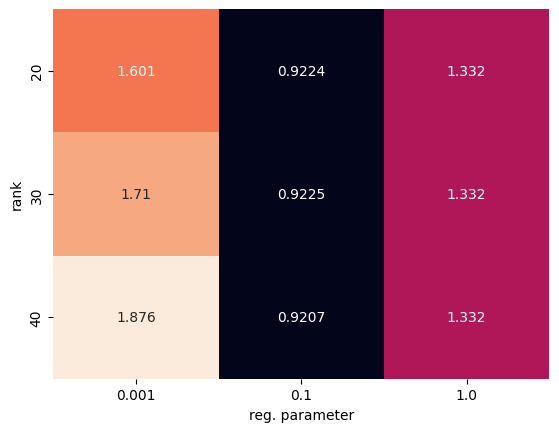

In [23]:

rmse_df = pd.DataFrame(data=rmse_score_array, index=pd.Index(param_dict["rank"], name="rank"), 
                       columns=pd.Index(param_dict["regParam"], name="reg. parameter"))

fig, ax = plt.subplots()
sns.heatmap(rmse_df, cbar=False, annot=True, fmt=".4g")

with rank 20 and reg is 0.1 is the best one, let's try again

### 2nd time

In [24]:
param_dict = {
    "rank": [20, 30, 40],
    "regParam": [0.1]
    # 'maxIter': [7, 10, 15, 20]
}
param_grid = generate_param_grid(param_dict)
param_grid

[{'rank': 20, 'regParam': 0.1},
 {'rank': 30, 'regParam': 0.1},
 {'rank': 40, 'regParam': 0.1}]

In [25]:
rmse_score_2 = []

for g in param_grid:
    als = ALS(        
        userCol=USER_COL, 
        itemCol=ITEM_COL, 
        ratingCol=RATING_COL, 
        coldStartStrategy="drop",
        **g # assigning each of param
    )
    
    model = als.fit(df_train)
    
    df_test_pred = model.transform(df_test).drop(RATING_COL)
    df_train_pred = model.transform(df_train).drop(RATING_COL)
    
    evaluations_test = SparkRatingEvaluation(
        df_test, 
        df_test_pred,
        col_user=USER_COL,
        col_item=ITEM_COL,
        col_rating=RATING_COL,
        col_prediction=PREDICT_COL
    )
    evaluations_train = SparkRatingEvaluation(
        df_train, 
        df_train_pred,
        col_user=USER_COL,
        col_item=ITEM_COL,
        col_rating=RATING_COL,
        col_prediction=PREDICT_COL
    )

    rmse_score_2.append(
        (evaluations_train.rmse(), evaluations_test.rmse())
    )

# rmse_score = [float('%.4f' % x) for x in rmse_score]
# rmse_score_array = np.reshape(
#     rmse_score, (len(param_dict["rank"]), len(param_dict["regParam"]))
#     ) 

In [26]:
rmse_score_2

[(0.48986806164588614, 0.9223643448033909),
 (0.46050374562207497, 0.9225298294114641),
 (0.4495168666327692, 0.920661575636474)]

In [27]:
print('regParam', param_dict['regParam'])
pd.DataFrame(
    rmse_score_2, 
    columns = ['rmse_trainset', 'rmse_testset'], 
    index = param_dict['rank'])\
    .style.background_gradient()

regParam [0.1]


,rmse_trainset,rmse_testset
20,0.489868,0.922364
30,0.460504,0.922530
40,0.449517,0.920662


> The best param so far is: regParam = 0.1, rank = 40

## Train model again with: regParam = 0.1, rank = 40

In [28]:
als_fn = ALS(        
    userCol=USER_COL, 
    itemCol=ITEM_COL, 
    ratingCol=RATING_COL, 
    coldStartStrategy="drop",
    maxIter= 10, 
    regParam= 0.1,
    rank= 40
)

model = als_fn.fit(mv_rating)

## Top K Recommend for each customer

In [29]:
df_rec_user = model.recommendForAllUsers(REC_QUANTITY)

In [30]:
df_rec_user.show(truncate = False)

+------+----------------------------------------------------------------------------------------------------+
|userId|recommendations                                                                                     |
+------+----------------------------------------------------------------------------------------------------+
|1     |[{1235, 3.3841295}, {920, 3.383904}, {2563, 3.3814042}, {121231, 3.3782494}, {1172, 3.3735275}]     |
|2     |[{83411, 4.552683}, {83359, 4.552683}, {83318, 4.552683}, {67504, 4.552683}, {969, 4.475658}]       |
|3     |[{83411, 4.541775}, {83359, 4.541775}, {83318, 4.541775}, {67504, 4.541775}, {65037, 4.49433}]      |
|4     |[{83411, 6.0478992}, {83359, 6.0478992}, {83318, 6.0478992}, {67504, 6.0478992}, {80599, 5.44311}]  |
|5     |[{65037, 4.6103864}, {59684, 4.6103864}, {318, 4.5586295}, {31435, 4.550513}, {54328, 4.5478578}]   |
|6     |[{83411, 4.841522}, {83359, 4.841522}, {83318, 4.841522}, {67504, 4.841522}, {7502, 4.5284452}]     |
|7     |[{

In [31]:
# Expand recommendations:
df_rec_user_exp = df_rec_user.selectExpr(
    'userId', 'explode(recommendations) as recommendation'
    )
df_rec_user_exp.show()

+------+-------------------+
|userId|     recommendation|
+------+-------------------+
|     1|  {1235, 3.3841295}|
|     1|    {920, 3.383904}|
|     1|  {2563, 3.3814042}|
|     1|{121231, 3.3782494}|
|     1|  {1172, 3.3735275}|
|     2|  {83411, 4.552683}|
|     2|  {83359, 4.552683}|
|     2|  {83318, 4.552683}|
|     2|  {67504, 4.552683}|
|     2|    {969, 4.475658}|
|     3|  {83411, 4.541775}|
|     3|  {83359, 4.541775}|
|     3|  {83318, 4.541775}|
|     3|  {67504, 4.541775}|
|     3|   {65037, 4.49433}|
|     4| {83411, 6.0478992}|
|     4| {83359, 6.0478992}|
|     4| {83318, 6.0478992}|
|     4| {67504, 6.0478992}|
|     4|   {80599, 5.44311}|
+------+-------------------+
only showing top 20 rows



In [32]:
df_rec_user_exp.select('recommendation').collect()[:5]

[Row(recommendation=Row(movieId=1235, rating=3.384129524230957)),
 Row(recommendation=Row(movieId=920, rating=3.383903980255127)),
 Row(recommendation=Row(movieId=2563, rating=3.381404161453247)),
 Row(recommendation=Row(movieId=121231, rating=3.378249406814575)),
 Row(recommendation=Row(movieId=1172, rating=3.3735275268554688))]

In [33]:
# Get movieId from recommendation:
df_rec_user_exp = df_rec_user_exp.selectExpr(
    'userId',
    'recommendation.movieId as rec_movieId'
)
df_rec_user_exp.show()

+------+-----------+
|userId|rec_movieId|
+------+-----------+
|     1|       1235|
|     1|        920|
|     1|       2563|
|     1|     121231|
|     1|       1172|
|     2|      83411|
|     2|      83359|
|     2|      83318|
|     2|      67504|
|     2|        969|
|     3|      83411|
|     3|      83359|
|     3|      83318|
|     3|      67504|
|     3|      65037|
|     4|      83411|
|     4|      83359|
|     4|      83318|
|     4|      67504|
|     4|      80599|
+------+-----------+
only showing top 20 rows



### Get movie names:

In [34]:
df_mv = spark.read.csv('data/movies.csv', header = True)
df_mv.show(truncate = False)

+-------+-------------------------------------+-------------------------------------------+
|movieId|title                                |genres                                     |
+-------+-------------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                     |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                       |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)              |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)             |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)   |Comedy                                     |
|6      |Heat (1995)                          |Action|Crime|Thriller                      |
|7      |Sabrina (1995)                       |Comedy|Romance                             |
|8      |Tom and Huck (1995)                  |Adventure|Children               

In [35]:
df_mv.printSchema()

root
 |-- movieId: string (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



In [36]:
# Get rec movie names, genres
df_rec_user_exp.alias('df1').join(
    df_mv.alias('df2'),
    on = expr('df1.rec_movieId = df2.movieId'),
    how = 'left'
)\
    .groupBy('userId')\
    .agg(
        collect_list('rec_movieId').alias('rec_movieId'),
        collect_list('title').alias('rec_movieName'),
        collect_list('genres').alias('rec_genres') 
    )\
    .show(truncate = False)

+------+------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------+
|userId|rec_movieId                         |rec_movieName                                                                                                                                                                                                                     |rec_genres                                                                              |
+------+------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----

In [37]:
mv_rating.orderBy(mv_rating['rating'].desc())\
    .toPandas()\
    .groupby('userId')['movieId'].agg(
        top_5_movieId_seen = lambda x: list(x)[:5]
        ).reset_index()

,userId,top_5_movieId_seen
0,1,"[1172, 1953, 2105, 1339, 1029]"
1,2,"[17, 39, 150, 222, 265]"
2,3,"[318, 356, 1197, 2959, 3949]"
3,4,"[34, 112, 141, 260, 296]"
4,5,"[597, 1035, 1380, 2081, 33166]"
...,...,...
666,667,"[32, 41, 144, 272, 296]"
667,668,"[296, 593, 608, 1213, 1221]"
668,669,"[260, 913, 1304, 2959, 223]"
669,670,"[25, 47, 50, 318, 527]"


In [38]:
9/0

ZeroDivisionError: ignored

# ALS with Age and Gender

In [ ]:
mv_rating.show()

In [ ]:
age_gender_rating_df = mv_rating.select(
    'userId',
    'movieId',
    'rating',
    concat(mv_rating['age'], mv_rating['gender']).alias('age_gender')
)\
    .groupBy(['age_gender', 'movieId'])\
    .agg(
        mean('rating').alias('rating')
    ).withColumn('age_gender', col('age_gender').cast(IntegerType()))
age_gender_rating_df.show()

In [ ]:
AGE_GENDER_COL = 'age_gender'


### Evaluation

In [ ]:
als = ALS(        
    userCol=AGE_GENDER_COL, 
    itemCol=ITEM_COL, 
    ratingCol=RATING_COL, 
    coldStartStrategy="drop",
    maxIter= 10, 
    regParam= 0.1,
    rank= 40
)
# model_agegender = als.fit(mv_rating)

In [ ]:
param_dict = {
    "rank": [20, 30, 40],
    "regParam": [0.01, 0.1, 1]
    # 'maxIter': [7, 10, 15, 20]
}
param_grid = generate_param_grid(param_dict)
param_grid

In [ ]:
rmse_score_3 = []
df_train, df_test = age_gender_rating_df.randomSplit([0.7, 0.3], seed = 96)

for g in param_grid:
    als = ALS(        
        userCol=AGE_GENDER_COL, 
        itemCol=ITEM_COL, 
        ratingCol=RATING_COL, 
        coldStartStrategy="drop",
        **g # assigning each of param
    )
    
    model = als.fit(df_train)
    
    df_test_pred = model.transform(df_test).drop(RATING_COL)
    df_train_pred = model.transform(df_train).drop(RATING_COL)
    
    evaluations_test = SparkRatingEvaluation(
        df_test, 
        df_test_pred,
        col_user=AGE_GENDER_COL,
        col_item=ITEM_COL,
        col_rating=RATING_COL,
        col_prediction=PREDICT_COL
    )
    evaluations_train = SparkRatingEvaluation(
        df_train, 
        df_train_pred,
        col_user=AGE_GENDER_COL,
        col_item=ITEM_COL,
        col_rating=RATING_COL,
        col_prediction=PREDICT_COL
    )

    rmse_score_3.append(
        (evaluations_train.rmse(), evaluations_test.rmse())
    )

# rmse_score = [float('%.4f' % x) for x in rmse_score]
# rmse_score_array = np.reshape(
#     rmse_score, (len(param_dict["rank"]), len(param_dict["regParam"]))
#     ) 

In [ ]:
rmse_score_3

In [ ]:
pd.DataFrame(
    rmse_score_3, 
    columns = ['rmse_trainset', 'rmse_testset'],
    index = param_grid)\
    .reset_index()\
    .style.background_gradient()

> best param is: rank = 40, regParam: 0.1

### Train model again with regParam = 0.1, rank = 40

In [ ]:
als_fn = ALS(        
    userCol=AGE_GENDER_COL, 
    itemCol=ITEM_COL, 
    ratingCol=RATING_COL, 
    coldStartStrategy="drop",
    maxIter= 10, 
    regParam= 0.1,
    rank= 40
)

model_age_gender = als_fn.fit(age_gender_rating_df)